In [149]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

kernel_h = kernel_w = 7
width = 51
height = 39
tile_dim = 22
blockDim_x = 512 # CUDA THREADS
# =============


k_radius = (kernel_h - 1) / 2;
shared_mem_length = (tile_dim + 2 * k_radius);
shared_mem_size = (shared_mem_length * shared_mem_length + kernel_h * kernel_w) * 4; #* sizeof(Dtype);

tiles_per_row = width / tile_dim + 1;
tiles_per_col = height / tile_dim + 1;
z_blocks = (tiles_per_col  * tiles_per_row);


print "tiles_per_row: {}; tiles_per_col: {}; z_blocks: {}\nshared_mem_length: {}; shared_mem_size: {} / 4".format(tiles_per_col, tiles_per_row, z_blocks, shared_mem_length, shared_mem_size)


tiles_per_row: 2; tiles_per_col: 3; z_blocks: 6
shared_mem_length: 28; shared_mem_size: 3332 / 4


In [156]:
def calc_coord_maxconv_fast(src, tile_idx, threads):
    y_tile_idx = (tile_idx / tiles_per_row);
    x_tile_idx = (tile_idx % tiles_per_row);
    print "y_tile_idx: {}; x_tile_idx: {}".format(y_tile_idx, x_tile_idx)
    
    y_offset = y_tile_idx * tile_dim;
    x_offset = x_tile_idx * tile_dim;

    y_start = y_offset - k_radius;
    x_start = x_offset - k_radius;   
    
    print "y_offset: {}; x_offset: {}; y_start: {}; x_start: {}".format(y_offset, x_offset, y_start, x_start)
    shared_data_size = shared_mem_length * shared_mem_length;
    copy_count = (shared_data_size / blockDim_x) + 1;
    print "shared_data_size: {}; copy_count: {}".format(shared_data_size, copy_count)
    
    shared_mem = np.zeros(shared_mem_length * shared_mem_length)
    
    src2 = np.copy(src)
    
    for thread_idx in xrange(threads):
        inner_offset = thread_idx * copy_count;
        #print "thread_idx: {}; inner_offset: {}".format(thread_idx, inner_offset)
        
        for i in xrange(copy_count):
            copy_offset = inner_offset + i
            shared_mem_y_offset = copy_offset / shared_mem_length;
            shared_mem_x_offset = copy_offset % shared_mem_length;
            src_y = y_start + shared_mem_y_offset;
            src_x = x_start + shared_mem_x_offset;
            
            if copy_offset < shared_data_size:
                if (src_y < 0 or src_x < 0 or src_x >= width or src_y >= height):
                    shared_mem[copy_offset] = 0
                else:                    
                    shared_mem[copy_offset] = src[src_y, src_x]
                    src2[src_y, src_x] = 1 - src[src_y, src_x]
    
    return src2, shared_mem.reshape((shared_mem_length, shared_mem_length))

(39, 51, 3)
y_tile_idx: 0; x_tile_idx: 0
y_offset: 0; x_offset: 0; y_start: -3; x_start: -3
shared_data_size: 784; copy_count: 2
(39, 51)
y_tile_idx: 0; x_tile_idx: 1
y_offset: 0; x_offset: 22; y_start: -3; x_start: 19
shared_data_size: 784; copy_count: 2
(39, 51)
y_tile_idx: 0; x_tile_idx: 2
y_offset: 0; x_offset: 44; y_start: -3; x_start: 41
shared_data_size: 784; copy_count: 2
(39, 51)
y_tile_idx: 1; x_tile_idx: 0
y_offset: 22; x_offset: 0; y_start: 19; x_start: -3
shared_data_size: 784; copy_count: 2
(39, 51)
y_tile_idx: 1; x_tile_idx: 1
y_offset: 22; x_offset: 22; y_start: 19; x_start: 19
shared_data_size: 784; copy_count: 2
(39, 51)
y_tile_idx: 1; x_tile_idx: 2
y_offset: 22; x_offset: 44; y_start: 19; x_start: 41
shared_data_size: 784; copy_count: 2
(39, 51)


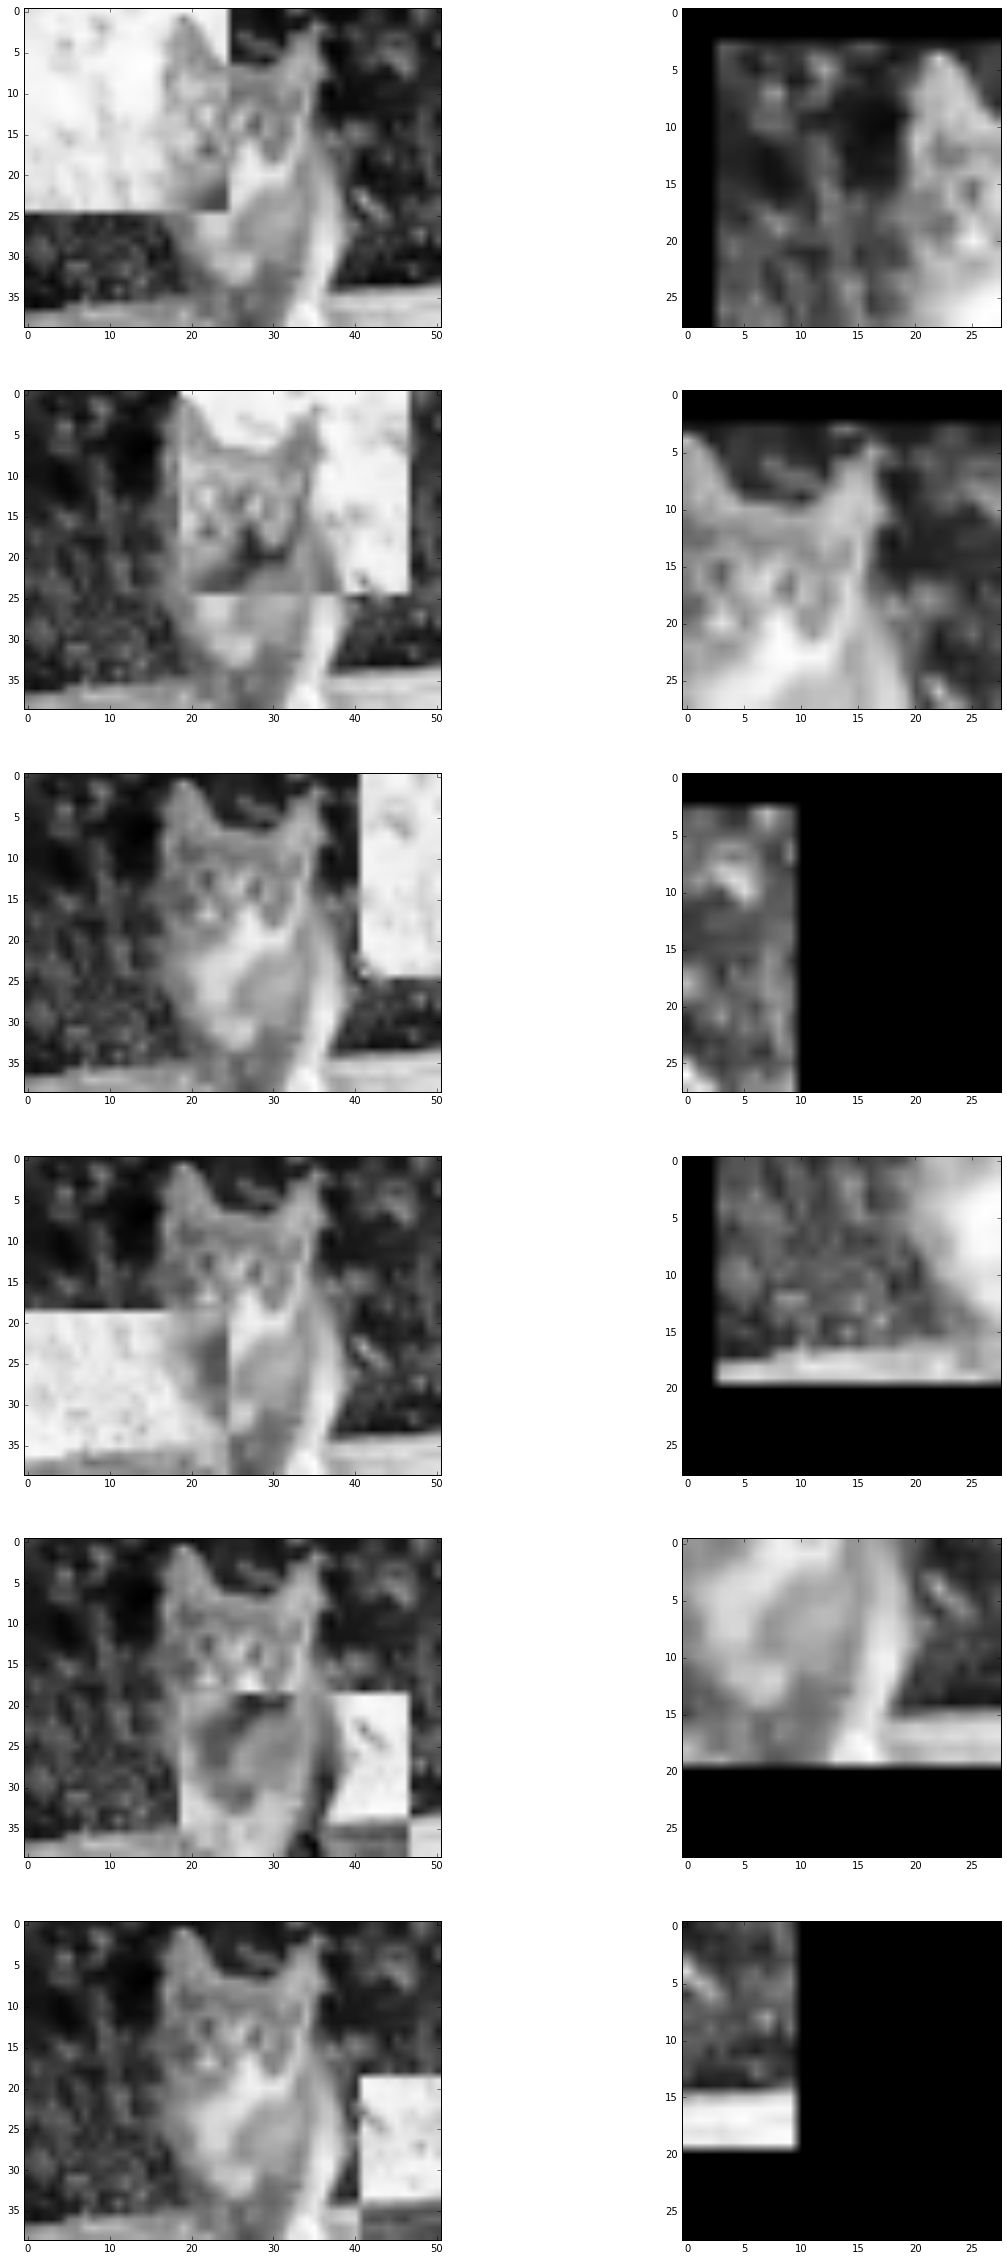

In [157]:
#src = np.random.rand(height, width)
src = cv2.imread('cat.jpg')
print src.shape

f, ax = plt.subplots(z_blocks, 2, figsize=(20,40))

for i in xrange(z_blocks):
    #print "Z-BLOCK: {}".format(i)
    img, shared_mem = calc_coord_maxconv_fast(src[:,:,0], i, 512)
    
    print img.shape

    #f, axarr = plt.subplots(1, 2, sharey=True)
    ax[i][0].imshow(img, cmap='Greys_r')
    ax[i][1].imshow(shared_mem, cmap='Greys_r')
    
    #print "---------------------\n"